<a href="https://colab.research.google.com/github/awermenlinger/BroadbandAndHappiness/blob/main/Happiness_and_Broadband_For_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Drive Connection

In [ ]:
import pandas as pd
import numpy as np
import regex as re
import math
import altair as alt
import plotly as plt
import plotly.express as px
from statsmodels.api import OLS
from itertools import combinations
from itertools import product
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
  # Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Data Load & Cleaning

## Broadband data

In [ ]:
#load the file - Please ignore for teaching staff (use the files in the zip)
id = "1PClUtLQPabDikQBM0W6kZFwql0QjHfog"
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Internet_access_data.xlsx')  

In [ ]:
#importing the Broadband Data
df = pd.read_excel('Internet_access_data.xlsx')
df.head()

,Series Name,Series Code,Country Name,Country Code,1990 [YR1990],2000 [YR2000],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020]
0,Fixed broadband subscriptions,IT.NET.BBND,Afghanistan,AFG,..,..,..,1500,1500,1500,7067,8801,9182,15999,19683,..
1,Fixed broadband subscriptions,IT.NET.BBND,Albania,ALB,..,..,128210,160088,182556,207964,242870,266379,303612,361947,436192,..
2,Fixed broadband subscriptions,IT.NET.BBND,Algeria,DZA,..,..,980752,1154748,1280000,1599692,2269348,2859567,3210267,3067022,3582739,..
3,Fixed broadband subscriptions,IT.NET.BBND,American Samoa,ASM,..,..,..,..,..,..,..,..,..,..,..,..
4,Fixed broadband subscriptions,IT.NET.BBND,Andorra,AND,..,..,25763,26905,27734,28770,30694,32490,34284,35663,36358,..


In [ ]:
#renaming the year columns
df = df.rename({'1990 [YR1990]':'1990','2000 [YR2000]':'2000','2011 [YR2011]':'2011','2012 [YR2012]':'2012','2013 [YR2013]':'2013','2014 [YR2014]':'2014',
                      '2015 [YR2015]':'2015','2016 [YR2016]':'2016','2017 [YR2017]':'2017','2018 [YR2018]':'2018','2019 [YR2019]':'2019'
                      ,'2020 [YR2020]':'2020'}, axis='columns')
df.head(2)

,Series Name,Series Code,Country Name,Country Code,1990,2000,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Fixed broadband subscriptions,IT.NET.BBND,Afghanistan,AFG,..,..,..,1500,1500,1500,7067,8801,9182,15999,19683,..
1,Fixed broadband subscriptions,IT.NET.BBND,Albania,ALB,..,..,128210,160088,182556,207964,242870,266379,303612,361947,436192,..


**Broadband subscriptions data**

In [ ]:
#dataset for broadband subscriptions
df_bb = df.loc[:263,:]
df_bb.tail(2)

,Series Name,Series Code,Country Name,Country Code,1990,2000,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
262,Fixed broadband subscriptions,IT.NET.BBND,Upper middle income,UMC,..,156516,244742644,277096704,303253049,323317248,408638365,462961275,552306792,578532565,625384639,..
263,Fixed broadband subscriptions,IT.NET.BBND,World,WLD,..,..,597998487,648909075,689543829,727250716,840118980,915928599,1025082012,1068680946,1134315607,..


In [ ]:
#converting the year columns to numeric to get the descriptive stats to check the average number of broadband connections over the years
cols = ['2000','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
df_bb[cols] = df_bb[cols].apply(pd.to_numeric,errors='coerce', axis=1)

df_bb.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Series Name   264 non-null    object 
 1   Series Code   264 non-null    object 
 2   Country Name  264 non-null    object 
 3   Country Code  264 non-null    object 
 4   1990          264 non-null    object 
 5   2000          58 non-null     float64
 6   2011          235 non-null    float64
 7   2012          243 non-null    float64
 8   2013          247 non-null    float64
 9   2014          247 non-null    float64
 10  2015          248 non-null    float64
 11  2016          243 non-null    float64
 12  2017          243 non-null    float64
 13  2018          223 non-null    float64
 14  2019          207 non-null    float64
 15  2020          0 non-null      float64
dtypes: float64(11), object(5)
memory usage: 33.1+ KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#keeping relevant columns
df_bb = df_bb.drop(['Series Name','Series Code', 'Country Code', '1990','2000','2020'], axis=1)
df_bb.head()

,Country Name,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,NaN,1500.0,1500.0,1500.0,7067.0,8801.0,9182.0,15999.0,19683.0
1,Albania,128210.0,160088.0,182556.0,207964.0,242870.0,266379.0,303612.0,361947.0,436192.0
2,Algeria,980752.0,1154748.0,1280000.0,1599692.0,2269348.0,2859567.0,3210267.0,3067022.0,3582739.0
3,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,25763.0,26905.0,27734.0,28770.0,30694.0,32490.0,34284.0,35663.0,36358.0


In [ ]:
df_bb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  264 non-null    object 
 1   2011          235 non-null    float64
 2   2012          243 non-null    float64
 3   2013          247 non-null    float64
 4   2014          247 non-null    float64
 5   2015          248 non-null    float64
 6   2016          243 non-null    float64
 7   2017          243 non-null    float64
 8   2018          223 non-null    float64
 9   2019          207 non-null    float64
dtypes: float64(9), object(1)
memory usage: 20.8+ KB


In [ ]:
#removing the clubbed regions to see the descriptive stats
df_bb1 = df_bb.iloc[:217,:]
df_bb1.tail(3)

,Country Name,2011,2012,2013,2014,2015,2016,2017,2018,2019
214,"Yemen, Rep.",109000.0,167300.0,256800.0,340000.0,395000.0,276219.0,369004.0,386330.0,NaN
215,Zambia,16415.0,14999.0,13447.0,20521.0,23390.0,31784.0,35912.0,72228.0,88891.0
216,Zimbabwe,34000.0,71905.0,103916.0,152234.0,163987.0,170838.0,187310.0,203056.0,204424.0


In [ ]:
df_bb1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  217 non-null    object 
 1   2011          192 non-null    float64
 2   2012          197 non-null    float64
 3   2013          201 non-null    float64
 4   2014          201 non-null    float64
 5   2015          202 non-null    float64
 6   2016          197 non-null    float64
 7   2017          197 non-null    float64
 8   2018          178 non-null    float64
 9   2019          164 non-null    float64
dtypes: float64(9), object(1)
memory usage: 17.1+ KB


In [ ]:
#checking the descriptive stats without any manipulation to see the trend 
pd.set_option('display.float_format', lambda x: '%.1f' % x)

df_bb1.describe()

,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,192.0,197.0,201.0,201.0,202.0,197.0,197.0,178.0,164.0
mean,3085846.6,3261219.6,3395681.1,3581164.7,4131003.2,4620520.8,5174459.1,5971662.5,6881000.9
std,13635969.8,14768443.5,15610671.8,16412968.0,21300060.4,24653695.6,29517709.4,32034059.9,36533592.6
min,0.0,0.0,0.0,0.0,117.0,110.0,111.0,87.0,68.0
25%,13508.5,14328.0,14604.0,15610.0,17064.8,20821.0,22235.0,33114.5,53970.5
50%,114909.5,123046.0,140816.0,161498.0,188125.5,232385.0,285093.0,378914.0,465283.0
75%,1223024.2,1432800.0,1525325.0,1706313.0,1791845.8,2106975.0,2342000.0,2673144.5,3195984.0
max,156487000.0,175183000.0,188909000.0,200483000.0,277046000.0,322597000.0,394190000.0,407382000.0,449279000.0


In [ ]:
df_bb1 = df_bb1.set_index('Country Name')

In [ ]:
#taking the total number of connections over the years by skipping NA. 

x1 = df_bb1.sum(axis = 0, skipna = True).to_frame().reset_index()
x2 = x1.rename(columns={'index':'Year',0:'Connections'})
x2

,Year,Connections
0,2011,592482555.0
1,2012,642460252.0
2,2013,682531895.0
3,2014,719814096.0
4,2015,834462650.0
5,2016,910242596.0
6,2017,1019368444.0
7,2018,1062955924.0
8,2019,1128484140.0


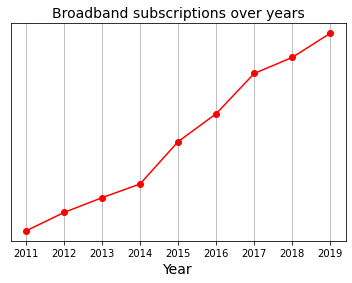

In [ ]:
#basic line chart for broadband subscriptions over the years
import matplotlib.pyplot as plt

plt.plot(x2['Year'],x2['Connections'], color='red', marker='o')
plt.title('Broadband subscriptions over years', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.yticks([])
plt.grid(True)
plt.show()


 Final Dataframe (df_ia_fin) on **Individuals using the Internet (% of the population)**

In [ ]:
#Individual using the internet
df_ia = df.loc[264:,:]
df_ia.head(2)

,Series Name,Series Code,Country Name,Country Code,1990,2000,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
264,Individuals using the Internet (% of population),IT.NET.USER.ZS,Afghanistan,AFG,0,..,5,5.5,5.9,7,8.3,..,11.4,..,..,..
265,Individuals using the Internet (% of population),IT.NET.USER.ZS,Albania,ALB,0,0.1,49,54.7,57.2,60.1,63.3,66.4,71.8,..,69.6,..


In [ ]:
#keeping relevant columns
df_ia = df_ia.drop(['Series Name','Series Code', 'Country Code', '1990','2000','2020'], axis=1)
df_ia.head()


,Country Name,2011,2012,2013,2014,2015,2016,2017,2018,2019
264,Afghanistan,5,5.5,5.9,7,8.3,..,11.4,..,..
265,Albania,49,54.7,57.2,60.1,63.3,66.4,71.8,..,69.6
266,Algeria,14.9,18.2,22.5,29.5,38.2,42.9,47.7,49.0,..
267,American Samoa,..,..,..,..,..,..,..,..,..
268,Andorra,81,86.4,94,95.9,96.9,97.9,91.6,..,..


In [ ]:
df_ia = df_ia.melt(id_vars=['Country Name'], var_name=['Year'], 
                       value_name='Individuals (%) with Internet access').sort_values(['Country Name','Year'])
df_ia.head(5)

,Country Name,Year,Individuals (%) with Internet access
0,Afghanistan,2011,5
269,Afghanistan,2012,5.5
538,Afghanistan,2013,5.9
807,Afghanistan,2014,7
1076,Afghanistan,2015,8.3


In [ ]:
df_ia_fin = df_ia.reset_index().drop(columns='index')
df_ia_fin.head(20)

,Country Name,Year,Individuals (%) with Internet access
0,Afghanistan,2011,5
1,Afghanistan,2012,5.5
2,Afghanistan,2013,5.9
3,Afghanistan,2014,7
4,Afghanistan,2015,8.3
5,Afghanistan,2016,..
6,Afghanistan,2017,11.4
7,Afghanistan,2018,..
8,Afghanistan,2019,..
9,Albania,2011,49


In [ ]:
df_ia_fin.replace("..", np.nan, inplace=True)
df_ia_fin.head(10)

,Country Name,Year,Individuals (%) with Internet access
0,Afghanistan,2011,5.0
1,Afghanistan,2012,5.5
2,Afghanistan,2013,5.9
3,Afghanistan,2014,7.0
4,Afghanistan,2015,8.3
5,Afghanistan,2016,nan
6,Afghanistan,2017,11.4
7,Afghanistan,2018,nan
8,Afghanistan,2019,nan
9,Albania,2011,49.0


In [ ]:
#handling the missing values
cols = list(df_ia_fin.columns)
cols.pop(0)
cols.pop(0)
df_ia_fin[cols] = df_ia_fin[cols].fillna(df_ia_fin.groupby('Country Name')[cols].ffill())
df_ia_fin[cols] = df_ia_fin[cols].fillna(df_ia_fin.groupby('Country Name')[cols].bfill())
df_ia_fin["Year"] = df_ia_fin["Year"].astype("int64")
df_ia_fin.head(20)

,Country Name,Year,Individuals (%) with Internet access
0,Afghanistan,2011,5.0
1,Afghanistan,2012,5.5
2,Afghanistan,2013,5.9
3,Afghanistan,2014,7.0
4,Afghanistan,2015,8.3
5,Afghanistan,2016,8.3
6,Afghanistan,2017,11.4
7,Afghanistan,2018,11.4
8,Afghanistan,2019,11.4
9,Albania,2011,49.0


## Happiness

In [ ]:
#load the file - Please ignore for teaching staff (use the files in the zip)
id = "17nrpjQt8wpSLACbk5HEAGNRQXRDmj9K3"
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('DataPanelWHR2021C2.xsl')

In [ ]:
df_whr = pd.read_excel('DataPanelWHR2021C2.xsl')

In [ ]:
df_whr.groupby("Country name")["year"].count()

Country name
Afghanistan    12
Albania        13
Algeria         8
Angola          4
Argentina      15
               ..
Venezuela      15
Vietnam        14
Yemen          12
Zambia         14
Zimbabwe       15
Name: year, Length: 166, dtype: int64

Some info: 
https://worldhappiness.report/ed/2019/changing-world-happiness/


In [ ]:
#Code to add missing years and forward fill based on previous years. If missing data from all prior years, backwards fill
#Adjsut the years to match the Broadband data so happiness report of 2019 is actually matching the 2018 broadband data
df_whr["year"] = df_whr["year"] - 1
df_whr = df_whr[df_whr["year"]>=2010]
missing_data = df_whr.groupby("Country name")["year"].count()
missing_data = missing_data[missing_data <10]
missing_data

Country name
Afghanistan            9
Algeria                7
Angola                 4
Armenia                9
Azerbaijan             9
                      ..
Trinidad and Tobago    3
Turkmenistan           9
Uzbekistan             9
Vietnam                9
Yemen                  9
Name: year, Length: 84, dtype: int64

In [ ]:
idx = list(product(df_whr['Country name'].unique(), df_whr['year'].unique()))
df_whr = df_whr.set_index(['Country name', 'year']).reindex(idx).reset_index()

In [ ]:
#Check ffill/bfill must be on same country
cols = list(df_whr.columns)
cols.pop(0)
cols.pop(0)
df_whr[cols] = df_whr[cols].fillna(df_whr.groupby('Country name')[cols].ffill())
df_whr[cols] = df_whr[cols].fillna(df_whr.groupby('Country name')[cols].bfill())

In [ ]:
df_whr_na = df_whr[df_whr.isna().any(axis=1)]
df_whr_na.groupby("Country name")["year"].count()

Country name
China                        10
Hong Kong S.A.R. of China    10
Jordan                       10
Kosovo                       10
Maldives                     10
North Cyprus                 10
Oman                         10
Palestinian Territories      10
Qatar                        10
Saudi Arabia                 10
Somalia                      10
Somaliland region            10
South Sudan                  10
Taiwan Province of China     10
Turkmenistan                 10
United Arab Emirates         10
Name: year, dtype: int64

In [ ]:
#Since the countries with missing information are missing it in all years, we can either remove or fillna with 0 for missing 
#to avoid skewing correlations, will remove the entries
df_whr.dropna(inplace=True)

In [ ]:
# dropdown filter
countries = df_whr["Country name"].unique()
country_dropdown = alt.binding_select(options=countries)
country_select = alt.selection_single(
    fields=["Country name"],
    bind=country_dropdown,
    name="Country",
)

# Create scatter plot
chart = (
    alt.Chart(df_whr)
    .mark_line()
    .encode(x="year:O", y="Life Ladder:Q")
    .add_selection(country_select)
    .transform_filter(country_select)
).properties(title="Happiness rating per country", width=600)
chart

alt.Chart(...)

In [ ]:
df_whr.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2010,3.8,7.6,0.5,51.9,0.5,0.2,0.7,0.6,0.3
1,Afghanistan,2011,3.8,7.7,0.5,52.2,0.5,0.2,0.8,0.7,0.3
2,Afghanistan,2012,3.6,7.7,0.5,52.6,0.6,0.1,0.8,0.6,0.3
3,Afghanistan,2013,3.1,7.7,0.5,52.9,0.5,0.1,0.9,0.5,0.4
4,Afghanistan,2014,4.0,7.7,0.5,53.2,0.4,0.1,0.9,0.6,0.3


In [ ]:
print("There are " + str(len(list(df_whr["Country name"].unique()))) + " countries")

There are 148 countries


In [ ]:
df_whr.groupby("year").mean()

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
year,,,,,,,,,
2010,5.4,9.2,0.8,61.8,0.7,-0.0,0.8,0.7,0.3
2011,5.3,9.2,0.8,62.1,0.7,0.0,0.8,0.7,0.3
2012,5.3,9.2,0.8,62.3,0.7,0.0,0.8,0.7,0.3
2013,5.3,9.3,0.8,62.6,0.7,0.0,0.7,0.7,0.3
2014,5.3,9.3,0.8,62.9,0.7,0.0,0.7,0.7,0.3
2015,5.3,9.3,0.8,63.2,0.8,0.0,0.7,0.7,0.3
2016,5.4,9.3,0.8,63.5,0.8,-0.0,0.7,0.7,0.3
2017,5.5,9.3,0.8,63.9,0.8,-0.0,0.7,0.7,0.3
2018,5.5,9.3,0.8,64.2,0.8,-0.0,0.7,0.7,0.3


## Align and Merge the two datasets

In [ ]:
whr_countries = set(df_whr["Country name"])
bb_countries = set(df_ia_fin["Country Name"])
c = whr_countries.difference(bb_countries)
print("WHR # of countries: " + str(len(whr_countries)))
print("WB # of countries: " + str(len(bb_countries)))


WHR # of countries: 148
WB # of countries: 265


In [ ]:
whr_countries = set(df_whr["Country name"])
bb_countries = set(df_ia_fin["Country Name"])
c = whr_countries.difference(bb_countries)
print(len(c))
print(c)

15
{'Congo (Brazzaville)', 'Yemen', 'South Korea', 'Gambia', 'Iran', 'Kyrgyzstan', 'Russia', 'Congo (Kinshasa)', 'Slovakia', 'Syria', 'Egypt', 'Venezuela', 'Swaziland', 'Ivory Coast', 'Laos'}


In [ ]:
c = bb_countries.difference(whr_countries)
print(len(c))
print(c)

132
{nan, 'Bermuda', 'Macao SAR, China', 'Tuvalu', 'Pre-demographic dividend', 'Channel Islands', 'IDA only', 'United Arab Emirates', 'IDA total', 'Monaco', 'IBRD only', 'China', 'Faroe Islands', 'South Asia (IDA & IBRD)', 'Middle East & North Africa (IDA & IBRD countries)', 'Latin America & Caribbean (excluding high income)', 'West Bank and Gaza', 'Caribbean small states', 'High income', 'Iran, Islamic Rep.', 'Europe & Central Asia (excluding high income)', 'Venezuela, RB', 'Arab World', 'Antigua and Barbuda', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Grenada', 'Other small states', 'IDA & IBRD total', 'St. Martin (French part)', 'Middle East & North Africa (excluding high income)', 'St. Vincent and the Grenadines', 'Kosovo', 'Low & middle income', 'Marshall Islands', 'Euro area', 'St. Kitts and Nevis', 'Low income', 'Maldives', 'Slovak Republic', 'Lower middle income', 'Curacao', 'Samoa', 'Not classified', 'South Sudan', 'Hong Kong SAR, China', 'Cayman Islands', 'European Union',

Build a dictionnary to replace the missing names in WHR (others will be dropped)

In [ ]:
dict_cty_replace = {"Congo (Brazzaville)" : "Congo, Rep.", "Congo (Kinshasa)" : "Congo, Dem. Rep.",
                    "Egypt" : "Egypt, Arab Rep.", "Gambia" : "Gambia, The", "Hong Kong S.A.R. of China": "Hong Kong SAR, China",
                    "Iran" : "Iran, Islamic Rep.", "Ivory Coast" : "Cote d'Ivoire", "Kyrgyzstan" : "Kyrgyz Republic",
                    "Laos" : "Lao PDR", "Russia" : "Russian Federation", "Slovakia" : "Slovak Republic", 
                    "South Korea" : "Korea, Rep.", "Swaziland" : "Eswatini", "Syria" : "Syrian Arab Republic", 
                    "Venezuela" : "Venezuela, RB", "Yemen" : "Yemen, Rep.", "Palestinian Territories" : "West Bank and Gaza"}

#Dropped countries and the reason why, same for why WHR as the baseline table
# North Cyprus - Not recognized 
# Somaliland region -  internationally considered to be part of Somalia
# Taiwan Province of China - internationally recognized (by some countries, but including the WB) as China

df_whr.replace({"Country name" : dict_cty_replace}, inplace=True)
df_whr[df_whr["Country name"] == "Slovak Republic"]

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1280,Slovak Republic,2010,5.9,10.2,0.9,67.0,0.7,0.0,0.9,0.6,0.3
1281,Slovak Republic,2011,5.9,10.2,0.9,67.3,0.6,-0.0,0.9,0.7,0.3
1282,Slovak Republic,2012,5.9,10.2,0.9,67.5,0.6,-0.1,0.9,0.7,0.3
1283,Slovak Republic,2013,6.1,10.2,0.9,67.8,0.6,-0.1,0.9,0.7,0.3
1284,Slovak Republic,2014,6.2,10.3,0.9,68.0,0.6,-0.1,0.9,0.7,0.3
1285,Slovak Republic,2015,6.0,10.3,0.9,68.3,0.7,-0.1,0.9,0.8,0.2
1286,Slovak Republic,2016,6.4,10.3,0.9,68.6,0.7,-0.1,0.9,0.8,0.2
1287,Slovak Republic,2017,6.2,10.4,0.9,68.9,0.8,-0.2,0.9,0.8,0.3
1288,Slovak Republic,2018,6.2,10.4,0.9,69.2,0.8,-0.1,0.9,0.8,0.3
1289,Slovak Republic,2019,6.5,10.3,1.0,69.5,0.8,-0.1,0.9,0.8,0.3


In [ ]:
df_ia_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 3 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country Name                          2376 non-null   object 
 1   Year                                  2421 non-null   int64  
 2   Individuals (%) with Internet access  2295 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 56.9+ KB


Merge the two datasets (inner join)

In [ ]:
merged_data = df_whr.merge(df_ia_fin, how="inner", left_on=["Country name", "year"], right_on=["Country Name", "Year"])
merged_data = merged_data.drop(columns=['Country Name', 'Year'])
merged_data.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Individuals (%) with Internet access
0,Afghanistan,2011,3.8,7.7,0.5,52.2,0.5,0.2,0.8,0.7,0.3,5.0
1,Afghanistan,2012,3.6,7.7,0.5,52.6,0.6,0.1,0.8,0.6,0.3,5.5
2,Afghanistan,2013,3.1,7.7,0.5,52.9,0.5,0.1,0.9,0.5,0.4,5.9
3,Afghanistan,2014,4.0,7.7,0.5,53.2,0.4,0.1,0.9,0.6,0.3,7.0
4,Afghanistan,2015,4.2,7.7,0.6,53.0,0.5,0.0,0.8,0.6,0.3,8.3


# EDA

SPLOM using Plotly

In [ ]:
import plotly.graph_objs as go
index_vals = merged_data['year'].astype('category').cat.codes
fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='Happiness',
                                 values=merged_data['Life Ladder']),
                            dict(label='GDP',
                                 values=merged_data['Log GDP per capita']),
                            dict(label='Social support',
                                 values=merged_data['Social support']),
                            dict(label='Life expectancy',
                                 values=merged_data['Healthy life expectancy at birth']),
                            dict(label='Freedom',
                                 values=merged_data['Freedom to make life choices']),
                            dict(label='Generosity',
                                 values=merged_data['Generosity']),
                            dict(label='Corruption',
                                 values=merged_data['Perceptions of corruption']),
                            dict(label='Positive',
                                 values=merged_data['Positive affect']),
                            dict(label='Negative',
                                 values=merged_data['Negative affect']),
                            dict(label='Internet access',
                                 values=merged_data['Individuals (%) with Internet access'])],
                diagonal_visible=False, # remove plots on diagonal
                text=merged_data['year'],
                marker=dict(color=index_vals,
                            showscale=True, # colors encode categorical variables
                            line_color='white', line_width=0.5)
                ))

fig.update_layout(
    title='SPLOM full dataset',
    autosize=False,
    width=1400,
    height=1200,
)

fig.show()

In [ ]:
corrMatrix = merged_data.drop("year", axis=1).corr().reset_index().melt('index')
corrMatrix.columns = ['var1', 'var2', 'correlation']

base = alt.Chart(corrMatrix).transform_filter(
    alt.datum.var1 < alt.datum.var2
).encode(
    x='var1',
    y='var2',
).properties(
    width=alt.Step(50),
    height=alt.Step(50)
)

rects = base.mark_rect().encode(
    color='correlation'
)

text = base.mark_text(
    size=15
).encode(
    text=alt.Text('correlation', format=".2f"),
    color=alt.condition(
        "datum.correlation > 0.5",
        alt.value('white'),
        alt.value('black')
    )
)

rects + text

alt.LayerChart(...)

In [ ]:
#correlation matrix
corr = merged_data.drop("year", axis=1).corr(method ='pearson')
corr

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Individuals (%) with Internet access
Life Ladder,1.0,0.8,0.7,0.8,0.6,0.1,-0.4,0.5,-0.4,0.8
Log GDP per capita,0.8,1.0,0.7,0.9,0.4,-0.0,-0.3,0.3,-0.3,0.9
Social support,0.7,0.7,1.0,0.7,0.4,0.0,-0.2,0.5,-0.5,0.7
Healthy life expectancy at birth,0.8,0.9,0.7,1.0,0.4,0.0,-0.3,0.3,-0.3,0.8
Freedom to make life choices,0.6,0.4,0.4,0.4,1.0,0.3,-0.4,0.6,-0.3,0.4
Generosity,0.1,-0.0,0.0,0.0,0.3,1.0,-0.3,0.3,-0.0,-0.0
Perceptions of corruption,-0.4,-0.3,-0.2,-0.3,-0.4,-0.3,1.0,-0.3,0.3,-0.3
Positive affect,0.5,0.3,0.5,0.3,0.6,0.3,-0.3,1.0,-0.4,0.3
Negative affect,-0.4,-0.3,-0.5,-0.3,-0.3,-0.0,0.3,-0.4,1.0,-0.3
Individuals (%) with Internet access,0.8,0.9,0.7,0.8,0.4,-0.0,-0.3,0.3,-0.3,1.0


In [ ]:
#fin_data dataset with only correlated variables, life ladder, log GDP per capita, Individuals (%) with Internet access

fin_data = merged_data[['Country name','year', 'Life Ladder','Log GDP per capita','Individuals (%) with Internet access']]
fin_data.head()

,Country name,year,Life Ladder,Log GDP per capita,Individuals (%) with Internet access
0,Afghanistan,2011,3.8,7.7,5.0
1,Afghanistan,2012,3.6,7.7,5.5
2,Afghanistan,2013,3.1,7.7,5.9
3,Afghanistan,2014,4.0,7.7,7.0
4,Afghanistan,2015,4.2,7.7,8.3


In [ ]:
Hap_int_df = fin_data[['Life Ladder','Individuals (%) with Internet access']].groupby(fin_data['year']).mean().reset_index()
Hap_int_df.head(2)

,year,Life Ladder,Individuals (%) with Internet access
0,2011,5.3,35.5
1,2012,5.3,38.4


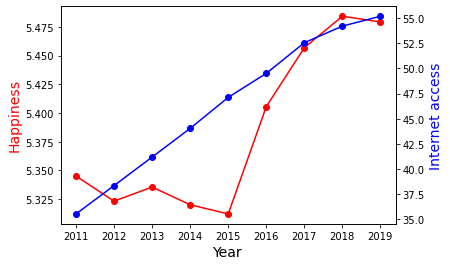

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(Hap_int_df['year'], Hap_int_df['Life Ladder'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Year",fontsize=14)
# set y-axis label
ax.set_ylabel("Happiness",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(Hap_int_df['year'], Hap_int_df['Individuals (%) with Internet access'],color="blue",marker="o")
ax2.set_ylabel("Internet access",color="blue",fontsize=14)
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [ ]:
gdp_int_df = fin_data[['Log GDP per capita','Individuals (%) with Internet access']].groupby(fin_data['year']).mean().reset_index()
gdp_int_df.head(2)

,year,Log GDP per capita,Individuals (%) with Internet access
0,2011,9.2,35.5
1,2012,9.2,38.4


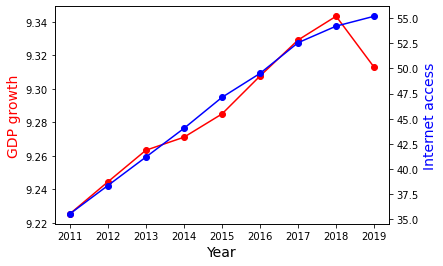

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(gdp_int_df['year'], gdp_int_df['Log GDP per capita'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Year",fontsize=14)
# set y-axis label
ax.set_ylabel("GDP growth",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(gdp_int_df['year'], gdp_int_df['Individuals (%) with Internet access'],color="blue",marker="o")
ax2.set_ylabel("Internet access",color="blue",fontsize=14)
plt.show()
# # save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [ ]:
hap_gdp_df = fin_data[['Life Ladder','Log GDP per capita']].groupby(fin_data['year']).mean().reset_index()
hap_gdp_df.head(2)

,year,Life Ladder,Log GDP per capita
0,2011,5.3,9.2
1,2012,5.3,9.2


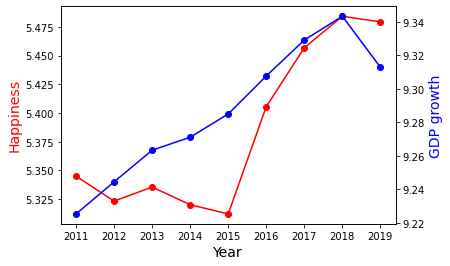

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(hap_gdp_df['year'], hap_gdp_df['Life Ladder'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Year",fontsize=14)
# set y-axis label
ax.set_ylabel("Happiness",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(hap_gdp_df['year'], hap_gdp_df['Log GDP per capita'],color="blue",marker="o")
ax2.set_ylabel("GDP growth",color="blue",fontsize=14)
plt.show()
# # save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [ ]:
reg_data = merged_data[['Log GDP per capita','Individuals (%) with Internet access']]
reg_tgt = merged_data['Life Ladder']

In [ ]:
reg_data_na = reg_data[reg_data.isna().any(axis=1)]
reg_data_na

,Log GDP per capita,Individuals (%) with Internet access


In [ ]:
OLS(reg_tgt,reg_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Life Ladder   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          4.266e+04
Date:                Mon, 24 May 2021   Prob (F-statistic):                        0.00
Time:                        10:46:12   Log-Likelihood:                         -1380.6
No. Observations:                1332   AIC:                                      2765.
Df Residuals:                    1330   BIC:                                      2776.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Log GDP per capita                       0.5251      0.005    115.707      0.000       0.516       0.534
Individuals (%) with Internet access     0.0110      0.001     14.213      0.000       0.009       0.012
==============================================================================
Omnibus:                       11.777   Durbin-Watson:                   0.469
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.267
Skew:                          -0.192   Prob(JB):                      0.00358
Kurtosis:                       2.763   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
reg_data = merged_data['Log GDP per capita']
reg_tgt = merged_data['Individuals (%) with Internet access']
OLS(reg_tgt,reg_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                         
=========================================================================================================
Dep. Variable:     Individuals (%) with Internet access   R-squared (uncentered):                   0.806
Model:                                              OLS   Adj. R-squared (uncentered):              0.806
Method:                                   Least Squares   F-statistic:                              5533.
Date:                                  Mon, 24 May 2021   Prob (F-statistic):                        0.00
Time:                                          10:46:12   Log-Likelihood:                         -6135.0
No. Observations:                                  1332   AIC:                                  1.227e+04
Df Residuals:                                      1331   BIC:                                  1.228e+04
Df Model:                                             1                                                  
Covariance Type:                              nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Log GDP per capita     5.2741      0.071     74.386      0.000       5.135       5.413
==============================================================================
Omnibus:                   134298.403   Durbin-Watson:                   0.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.723
Skew:                           0.105   Prob(JB):                     1.82e-23
Kurtosis:                       1.643   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
reg_data = merged_data.drop(['Life Ladder', "Country name", "year"], axis=1)
reg_tgt = merged_data['Life Ladder']

OLS(reg_tgt,reg_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Life Ladder   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          1.459e+04
Date:                Mon, 24 May 2021   Prob (F-statistic):                        0.00
Time:                        10:46:12   Log-Likelihood:                         -1093.5
No. Observations:                1332   AIC:                                      2205.
Df Residuals:                    1323   BIC:                                      2252.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Log GDP per capita                       0.1251      0.030      4.112      0.000       0.065       0.185
Social support                           1.8796      0.204      9.226      0.000       1.480       2.279
Healthy life expectancy at birth         0.0177      0.004      4.513      0.000       0.010       0.025
Freedom to make life choices             0.6065      0.153      3.972      0.000       0.307       0.906
Generosity                               0.3330      0.105      3.159      0.002       0.126       0.540
Perceptions of corruption               -0.6557      0.097     -6.731      0.000      -0.847      -0.465
Positive affect                          1.6063      0.195      8.246      0.000       1.224       1.988
Negative affect                         -0.1838      0.198     -0.930      0.353      -0.572       0.204
Individuals (%) with Internet access     0.0118      0.001     12.756      0.000       0.010       0.014
==============================================================================
Omnibus:                       25.104   Durbin-Watson:                   0.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.800
Skew:                          -0.274   Prob(JB):                     5.57e-07
Kurtosis:                       3.467   Cond. No.                     1.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Top 10 GDP

In [ ]:
totalgdp = merged_data[merged_data["year"]==2019].copy()
totalgdp.set_index("Country name", inplace=True)
totalgdp = totalgdp["Log GDP per capita"].copy()
totalgdp.sort_values(ascending=False, inplace=True)
top10GDPcountries = list(totalgdp[:10].index)
top10GDP = merged_data[merged_data["Country name"].isin(top10GDPcountries)].copy()
top10GDP.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Individuals (%) with Internet access
63,Austria,2011,7.4,10.9,0.9,71.7,0.9,0.1,0.8,0.8,0.2,78.7
64,Austria,2012,7.5,10.9,0.9,71.8,0.9,0.2,0.7,0.8,0.2,80.0
65,Austria,2013,6.9,10.9,0.9,72.0,0.9,0.1,0.6,0.8,0.2,80.6
66,Austria,2014,7.1,10.9,0.9,72.1,0.9,0.1,0.6,0.8,0.2,81.0
67,Austria,2015,7.0,10.9,0.9,72.4,0.9,0.1,0.5,0.8,0.2,83.9


In [ ]:
gdp_graph = alt.Chart(top10GDP).mark_line().encode(
      x="year:O",
      y=alt.Y("Log GDP per capita",scale=alt.Scale(domain=[10, 12])),
      color="Country name"
).properties(width=600, height=500)
gdp_graph

alt.Chart(...)

In [ ]:
# dropdown filter
countries = top10GDP["Country name"].unique()
country_dropdown = alt.binding_select(options=countries)
country_select = alt.selection_single(
    fields=["Country name"],
    bind=country_dropdown,
    name="Country",
)

# Create scatter plot
chart_hap = (
    alt.Chart(top10GDP)
    .mark_line(color="green")
    .encode(x="year:O",
            y=alt.Y("Life Ladder",scale=alt.Scale(domain=[6, 9]), title="Happiness (green)")
    )
)

chart_gdp = (
    alt.Chart(top10GDP)
    .mark_line()
    .encode(x="year:O",
            y=alt.Y("Log GDP per capita",scale=alt.Scale(domain=[10, 12]))
    )
)

chart = chart_hap+chart_gdp
chart = chart.add_selection(country_select).transform_filter(country_select)
chart = chart.properties(width=600, height=400).resolve_scale(y = 'independent')
chart

alt.LayerChart(...)

In [ ]:
# dropdown filter
countries = top10GDP["Country name"].unique()
country_dropdown = alt.binding_select(options=countries)
country_select = alt.selection_single(
    fields=["Country name"],
    bind=country_dropdown,
    name="Country",
)

# Create scatter plot
chart_hap = (
    alt.Chart(top10GDP)
    .mark_line(color="green")
    .encode(x="year:O",
            y=alt.Y("Life Ladder",scale=alt.Scale(domain=[6, 9]), title="Happiness (green)")
    )
)

chart_gdp = (
    alt.Chart(top10GDP)
    .mark_line()
    .encode(x="year:O",
            y=alt.Y("Individuals (%) with Internet access",scale=alt.Scale(domain=[70, 100]))
    )
)

chart = chart_hap+chart_gdp
chart = chart.add_selection(country_select).transform_filter(country_select)
chart = chart.properties(width=600, height=400).resolve_scale(y = 'independent')
chart

alt.LayerChart(...)

In [ ]:
reg_data = top10GDP[['Log GDP per capita','Individuals (%) with Internet access']]
reg_tgt = top10GDP['Life Ladder']
OLS(reg_tgt,reg_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Life Ladder   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.610e+04
Date:                Mon, 24 May 2021   Prob (F-statistic):                   1.44e-113
Time:                        10:46:13   Log-Likelihood:                         -40.083
No. Observations:                  90   AIC:                                      84.17
Df Residuals:                      88   BIC:                                      89.17
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Log GDP per capita                       0.3624      0.043      8.505      0.000       0.278       0.447
Individuals (%) with Internet access     0.0362      0.005      6.800      0.000       0.026       0.047
==============================================================================
Omnibus:                       13.720   Durbin-Watson:                   0.442
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.808
Skew:                          -0.918   Prob(JB):                     0.000609
Kurtosis:                       3.759   Cond. No.                         95.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
US_df = top10GDP.copy()
US_df = US_df[US_df["Country name"]=="United States"]
reg_data = US_df[['Log GDP per capita','Individuals (%) with Internet access']]
reg_tgt = US_df['Life Ladder']
OLS(reg_tgt,reg_data).fit().summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=9



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Life Ladder   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              8832.
Date:                Mon, 24 May 2021   Prob (F-statistic):                    1.24e-12
Time:                        10:46:13   Log-Likelihood:                          4.9752
No. Observations:                   9   AIC:                                     -5.950
Df Residuals:                       7   BIC:                                     -5.556
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Log GDP per capita                       0.6846      0.052     13.098      0.000       0.561       0.808
Individuals (%) with Internet access    -0.0066      0.007     -0.920      0.388      -0.024       0.010
==============================================================================
Omnibus:                        0.060   Durbin-Watson:                   1.482
Prob(Omnibus):                  0.970   Jarque-Bera (JB):                0.197
Skew:                           0.133   Prob(JB):                        0.906
Kurtosis:                       2.326   Cond. No.                         80.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#correlation matrix
corr = top10GDP.copy()
corr.drop("year", inplace=True, axis=1)
corr = corr.corr(method ='pearson')
corr

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Individuals (%) with Internet access
Life Ladder,1.0,-0.5,0.5,-0.2,0.5,0.1,0.0,0.4,0.2,0.5
Log GDP per capita,-0.5,1.0,-0.3,0.4,-0.2,-0.5,-0.3,-0.4,-0.3,0.0
Social support,0.5,-0.3,1.0,-0.1,0.5,0.1,-0.0,0.2,0.2,0.3
Healthy life expectancy at birth,-0.2,0.4,-0.1,1.0,0.4,-0.4,-0.8,-0.3,-0.8,0.1
Freedom to make life choices,0.5,-0.2,0.5,0.4,1.0,-0.0,-0.5,0.3,-0.3,0.6
Generosity,0.1,-0.5,0.1,-0.4,-0.0,1.0,0.3,0.6,0.3,-0.2
Perceptions of corruption,0.0,-0.3,-0.0,-0.8,-0.5,0.3,1.0,0.1,0.6,-0.4
Positive affect,0.4,-0.4,0.2,-0.3,0.3,0.6,0.1,1.0,0.3,0.2
Negative affect,0.2,-0.3,0.2,-0.8,-0.3,0.3,0.6,0.3,1.0,-0.0
Individuals (%) with Internet access,0.5,0.0,0.3,0.1,0.6,-0.2,-0.4,0.2,-0.0,1.0


In [ ]:
index_vals = top10GDP['year'].astype('category').cat.codes
fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='Happiness',
                                 values=top10GDP['Life Ladder']),
                            dict(label='GDP',
                                 values=top10GDP['Log GDP per capita']),
                            dict(label='Social support',
                                 values=top10GDP['Social support']),
                            dict(label='Life expectancy',
                                 values=top10GDP['Healthy life expectancy at birth']),
                            dict(label='Freedom',
                                 values=top10GDP['Freedom to make life choices']),
                            dict(label='Generosity',
                                 values=top10GDP['Generosity']),
                            dict(label='Corruption',
                                 values=top10GDP['Perceptions of corruption']),
                            dict(label='Positive',
                                 values=top10GDP['Positive affect']),
                            dict(label='Negative',
                                 values=top10GDP['Negative affect']),
                            dict(label='Internet access',
                                 values=top10GDP['Individuals (%) with Internet access'])],
                diagonal_visible=False, # remove plots on diagonal
                text=top10GDP['year'],
                marker=dict(color=index_vals,
                            showscale=True, # colors encode categorical variables
                            line_color='white', line_width=0.5)
                ))

fig.update_layout(
    title='SPLOM full dataset',
    autosize=False,
    width=1200,
    height=1400,
)

fig.show()

In [ ]:
corrMatrix = top10GDP.drop("year", axis=1).corr().reset_index().melt('index')
corrMatrix.columns = ['var1', 'var2', 'correlation']

base = alt.Chart(corrMatrix).transform_filter(
    alt.datum.var1 < alt.datum.var2
).encode(
    x='var1',
    y='var2',
).properties(
    width=alt.Step(50),
    height=alt.Step(50)
)

rects = base.mark_rect().encode(
    color='correlation'
)

text = base.mark_text(
    size=15
).encode(
    text=alt.Text('correlation', format=".2f"),
    color=alt.condition(
        "datum.correlation > 0.5",
        alt.value('white'),
        alt.value('black')
    )
)

corrmatrix = rects + text
corrmatrix

alt.LayerChart(...)

## 20 Countries with lowest GDP Variance

In [ ]:
vargdp = merged_data.copy()
vargdp["GDP per capita"] = np.exp(vargdp["Log GDP per capita"])
vargdp = vargdp.groupby("Country name")["GDP per capita"].agg(['min', 'max'])
vargdp["variance"] = vargdp["max"] - vargdp["min"]
stable20countries = vargdp["variance"].copy()
stable20countries.sort_values(ascending=True, inplace=True)
stable20countries = list(stable20countries[:20].index)
stable20countries

['Djibouti',
 'Belize',
 'Suriname',
 'Haiti',
 'Afghanistan',
 'Malawi',
 'Sudan',
 'Madagascar',
 'Burundi',
 'Gambia, The',
 'Comoros',
 'Niger',
 'Congo, Dem. Rep.',
 'Zambia',
 'Liberia',
 'Uganda',
 'Angola',
 'Mozambique',
 'Chad',
 'Mauritania']

In [ ]:
Stable20GDP = merged_data[merged_data["Country name"].isin(stable20countries)].copy()
Stable20GDP.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Individuals (%) with Internet access
0,Afghanistan,2011,3.8,7.7,0.5,52.2,0.5,0.2,0.8,0.7,0.3,5.0
1,Afghanistan,2012,3.6,7.7,0.5,52.6,0.6,0.1,0.8,0.6,0.3,5.5
2,Afghanistan,2013,3.1,7.7,0.5,52.9,0.5,0.1,0.9,0.5,0.4,5.9
3,Afghanistan,2014,4.0,7.7,0.5,53.2,0.4,0.1,0.9,0.6,0.3,7.0
4,Afghanistan,2015,4.2,7.7,0.6,53.0,0.5,0.0,0.8,0.6,0.3,8.3


In [ ]:
hap_graph = alt.Chart(Stable20GDP).mark_line().encode(
      x="year:O",
      y=alt.Y("Life Ladder",scale=alt.Scale(domain=[2, 8])),
      color="Country name"
).properties(width=600, height=500)
hap_graph

alt.Chart(...)

In [ ]:
bb_graph = alt.Chart(top10GDP).mark_line().encode(
      x="year:O",
      y=alt.Y("Individuals (%) with Internet access",scale=alt.Scale(domain=[65, 100])),
      color="Country name"
).properties(width=600, height=500)
bb_graph

alt.Chart(...)

In [ ]:
corrMatrix = Stable20GDP.drop("year", axis=1).corr().reset_index().melt('index')
corrMatrix.columns = ['var1', 'var2', 'correlation']

base = alt.Chart(corrMatrix).transform_filter(
    alt.datum.var1 < alt.datum.var2
).encode(
    x='var1',
    y='var2',
).properties(
    width=alt.Step(50),
    height=alt.Step(50)
)

rects = base.mark_rect().encode(
    color='correlation'
)

text = base.mark_text(
    size=15
).encode(
    text=alt.Text('correlation', format=".2f"),
    color=alt.condition(
        "datum.correlation > 0.5",
        alt.value('white'),
        alt.value('black')
    )
)

corrmatrix = rects + text
corrmatrix

alt.LayerChart(...)

In [ ]:
reg_data = Stable20GDP[['Individuals (%) with Internet access', "Log GDP per capita"]]
reg_tgt = Stable20GDP['Life Ladder']
OLS(reg_tgt,reg_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Life Ladder   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              3998.
Date:                Mon, 24 May 2021   Prob (F-statistic):                   1.21e-148
Time:                        11:18:36   Log-Likelihood:                         -177.20
No. Observations:                 180   AIC:                                      358.4
Df Residuals:                     178   BIC:                                      364.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Individuals (%) with Internet access     0.0159      0.004      3.964      0.000       0.008       0.024
Log GDP per capita                       0.5222      0.010     52.054      0.000       0.502       0.542
==============================================================================
Omnibus:                        3.642   Durbin-Watson:                   0.633
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                3.703
Skew:                          -0.328   Prob(JB):                        0.157
Kurtosis:                       2.749   Cond. No.                         4.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
reg_data = Stable20GDP.drop(['Life Ladder', "Country name", "year"], axis=1)
reg_tgt = Stable20GDP['Life Ladder']

OLS(reg_tgt,reg_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Life Ladder   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              1608.
Date:                Mon, 24 May 2021   Prob (F-statistic):                   2.95e-160
Time:                        11:18:41   Log-Likelihood:                         -121.10
No. Observations:                 180   AIC:                                      260.2
Df Residuals:                     171   BIC:                                      288.9
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Log GDP per capita                       0.2533      0.079      3.209      0.002       0.097       0.409
Social support                           2.1323      0.436      4.895      0.000       1.273       2.992
Healthy life expectancy at birth        -0.0145      0.012     -1.210      0.228      -0.038       0.009
Freedom to make life choices             1.9571      0.308      6.355      0.000       1.349       2.565
Generosity                               0.3546      0.352      1.006      0.316      -0.341       1.050
Perceptions of corruption               -0.3073      0.445     -0.690      0.491      -1.186       0.571
Positive affect                          0.8595      0.527      1.632      0.104      -0.180       1.899
Negative affect                         -0.2148      0.563     -0.382      0.703      -1.326       0.897
Individuals (%) with Internet access     0.0101      0.004      2.625      0.009       0.002       0.018
==============================================================================
Omnibus:                        6.245   Durbin-Watson:                   0.849
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.269
Skew:                          -0.423   Prob(JB):                       0.0435
Kurtosis:                       2.653   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
reg_data = merged_data.drop(['Life Ladder', "Country name", "year"], axis=1)
reg_tgt = merged_data['Life Ladder']

OLS(reg_tgt,reg_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Life Ladder   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          1.459e+04
Date:                Mon, 24 May 2021   Prob (F-statistic):                        0.00
Time:                        11:18:50   Log-Likelihood:                         -1093.5
No. Observations:                1332   AIC:                                      2205.
Df Residuals:                    1323   BIC:                                      2252.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Log GDP per capita                       0.1251      0.030      4.112      0.000       0.065       0.185
Social support                           1.8796      0.204      9.226      0.000       1.480       2.279
Healthy life expectancy at birth         0.0177      0.004      4.513      0.000       0.010       0.025
Freedom to make life choices             0.6065      0.153      3.972      0.000       0.307       0.906
Generosity                               0.3330      0.105      3.159      0.002       0.126       0.540
Perceptions of corruption               -0.6557      0.097     -6.731      0.000      -0.847      -0.465
Positive affect                          1.6063      0.195      8.246      0.000       1.224       1.988
Negative affect                         -0.1838      0.198     -0.930      0.353      -0.572       0.204
Individuals (%) with Internet access     0.0118      0.001     12.756      0.000       0.010       0.014
==============================================================================
Omnibus:                       25.104   Durbin-Watson:                   0.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.800
Skew:                          -0.274   Prob(JB):                     5.57e-07
Kurtosis:                       3.467   Cond. No.                     1.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Bottom 10 GDP Countries

In [ ]:
totalgdp = merged_data[merged_data["year"]==2019].copy()
totalgdp.set_index("Country name", inplace=True)
totalgdp = totalgdp["Log GDP per capita"].copy()
totalgdp.sort_values(ascending=True, inplace=True)
bottom10GDPcountries = list(totalgdp[:10].index)
bottom10GDP = merged_data[merged_data["Country name"].isin(bottom10GDPcountries)].copy()
bottom10GDP.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Individuals (%) with Internet access
198,Burundi,2011,3.7,6.7,0.4,50.7,0.5,-0.1,0.7,0.7,0.2,1.1
199,Burundi,2012,3.7,6.7,0.4,50.7,0.5,-0.1,0.7,0.7,0.2,1.2
200,Burundi,2013,2.9,6.8,0.6,51.8,0.4,-0.1,0.8,0.7,0.3,1.3
201,Burundi,2014,2.9,6.8,0.6,51.8,0.4,-0.1,0.8,0.7,0.3,1.4
202,Burundi,2015,2.9,6.8,0.6,51.8,0.4,-0.1,0.8,0.7,0.3,4.9


In [ ]:
gdp_graph = alt.Chart(bottom10GDP).mark_line().encode(
      x="year:O",
      y=alt.Y("Log GDP per capita",scale=alt.Scale(domain=[6.5, 8])),
      color="Country name"
).properties(width=600, height=500)
gdp_graph

alt.Chart(...)

In [ ]:
# dropdown filter
countries = bottom10GDP["Country name"].unique()
country_dropdown = alt.binding_select(options=countries)
country_select = alt.selection_single(
    fields=["Country name"],
    bind=country_dropdown,
    name="Country",
)

# Create scatter plot
chart_hap = (
    alt.Chart(bottom10GDP)
    .mark_line(color="green")
    .encode(x="year:O",
            y=alt.Y("Life Ladder",scale=alt.Scale(domain=[2, 6]), title="Happiness (green)")
    )
)

chart_gdp = (
    alt.Chart(bottom10GDP)
    .mark_line()
    .encode(x="year:O",
            y=alt.Y("Log GDP per capita",scale=alt.Scale(domain=[6.5, 8]))
    )
)

chart = chart_hap+chart_gdp
chart = chart.add_selection(country_select).transform_filter(country_select)
chart = chart.properties(width=600, height=400).resolve_scale(y = 'independent')
chart

alt.LayerChart(...)

In [ ]:
# dropdown filter
countries = bottom10GDP["Country name"].unique()
country_dropdown = alt.binding_select(options=countries)
country_select = alt.selection_single(
    fields=["Country name"],
    bind=country_dropdown,
    name="Country",
)

# Create scatter plot
chart_hap = (
    alt.Chart(bottom10GDP)
    .mark_line(color="green")
    .encode(x="year:O",
            y=alt.Y("Life Ladder",scale=alt.Scale(domain=[2, 6]), title="Happiness (green)")
    )
)

chart_gdp = (
    alt.Chart(bottom10GDP)
    .mark_line()
    .encode(x="year:O",
            y=alt.Y("Individuals (%) with Internet access",scale=alt.Scale(domain=[0, 40]))
    )
)

chart = chart_hap+chart_gdp
chart = chart.add_selection(country_select).transform_filter(country_select)
chart = chart.properties(width=600, height=400).resolve_scale(y = 'independent')
chart

alt.LayerChart(...)

In [ ]:
reg_data = bottom10GDP[['Log GDP per capita','Individuals (%) with Internet access']]
reg_tgt = bottom10GDP['Life Ladder']
OLS(reg_tgt,reg_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Life Ladder   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              2109.
Date:                Mon, 24 May 2021   Prob (F-statistic):                    4.55e-75
Time:                        10:46:14   Log-Likelihood:                         -78.783
No. Observations:                  90   AIC:                                      161.6
Df Residuals:                      88   BIC:                                      166.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Log GDP per capita                       0.5465      0.013     41.063      0.000       0.520       0.573
Individuals (%) with Internet access     0.0210      0.012      1.814      0.073      -0.002       0.044
==============================================================================
Omnibus:                        0.828   Durbin-Watson:                   0.865
Prob(Omnibus):                  0.661   Jarque-Bera (JB):                0.924
Skew:                          -0.209   Prob(JB):                        0.630
Kurtosis:                       2.733   Cond. No.                         2.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#correlation matrix
corr = bottom10GDP.copy()
corr.drop("year", inplace=True, axis=1)
corr = corr.corr(method ='pearson')
corr

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Individuals (%) with Internet access
Life Ladder,1.0,0.2,0.6,0.2,0.3,0.3,-0.3,0.2,0.0,0.2
Log GDP per capita,0.2,1.0,0.3,0.2,-0.1,-0.1,0.3,-0.1,0.2,0.2
Social support,0.6,0.3,1.0,0.3,-0.1,-0.1,-0.0,0.2,-0.4,0.1
Healthy life expectancy at birth,0.2,0.2,0.3,1.0,0.1,0.0,-0.2,0.5,-0.2,0.3
Freedom to make life choices,0.3,-0.1,-0.1,0.1,1.0,0.4,-0.3,-0.1,0.1,0.5
Generosity,0.3,-0.1,-0.1,0.0,0.4,1.0,0.0,0.0,0.4,0.4
Perceptions of corruption,-0.3,0.3,-0.0,-0.2,-0.3,0.0,1.0,-0.1,0.2,-0.2
Positive affect,0.2,-0.1,0.2,0.5,-0.1,0.0,-0.1,1.0,-0.3,-0.1
Negative affect,0.0,0.2,-0.4,-0.2,0.1,0.4,0.2,-0.3,1.0,0.3
Individuals (%) with Internet access,0.2,0.2,0.1,0.3,0.5,0.4,-0.2,-0.1,0.3,1.0


In [ ]:
index_vals = bottom10GDP['year'].astype('category').cat.codes
fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='Happiness',
                                 values=bottom10GDP['Life Ladder']),
                            dict(label='GDP',
                                 values=bottom10GDP['Log GDP per capita']),
                            dict(label='Social support',
                                 values=bottom10GDP['Social support']),
                            dict(label='Life expectancy',
                                 values=bottom10GDP['Healthy life expectancy at birth']),
                            dict(label='Freedom',
                                 values=bottom10GDP['Freedom to make life choices']),
                            dict(label='Generosity',
                                 values=bottom10GDP['Generosity']),
                            dict(label='Corruption',
                                 values=bottom10GDP['Perceptions of corruption']),
                            dict(label='Positive',
                                 values=bottom10GDP['Positive affect']),
                            dict(label='Negative',
                                 values=bottom10GDP['Negative affect']),
                            dict(label='Internet access',
                                 values=bottom10GDP['Individuals (%) with Internet access'])],
                diagonal_visible=False, # remove plots on diagonal
                text=bottom10GDP['year'],
                marker=dict(color=index_vals,
                            showscale=True, # colors encode categorical variables
                            line_color='white', line_width=0.5)
                ))

fig.update_layout(
    title='SPLOM full dataset',
    autosize=False,
    width=1200,
    height=1200,
)

fig.show()

In [ ]:
corrMatrix = bottom10GDP.drop("year", axis=1).corr().reset_index().melt('index')
corrMatrix.columns = ['var1', 'var2', 'correlation']

base = alt.Chart(corrMatrix).transform_filter(
    alt.datum.var1 < alt.datum.var2
).encode(
    x='var1',
    y='var2',
).properties(
    width=alt.Step(50),
    height=alt.Step(50)
)

rects = base.mark_rect().encode(
    color='correlation'
)

text = base.mark_text(
    size=15
).encode(
    text=alt.Text('correlation', format=".2f"),
    color=alt.condition(
        "datum.correlation > 0.5",
        alt.value('white'),
        alt.value('black')
    )
)

corrmatrix = rects + text
corrmatrix

alt.LayerChart(...)

## Demographic "Christmas Tree" Diagram

In [ ]:
#This changes the dataframe to be usable for the demographic/christmas tree diagram
years = [2011, 2019]
xmas_df = merged_data.copy()
xmas_df = xmas_df[xmas_df["year"].isin(years)]
xmas_df = xmas_df[["Country name", "year", "Life Ladder", "Log GDP per capita", "Individuals (%) with Internet access"]]
xmas_df.columns = ["Country", "Year", "Happiness", "GDP", "Internet"]
xmas_df.set_index(["Country", "Year"], inplace=True)
xmas_df = xmas_df.unstack()
xmas_df.columns = [''.join(str(col)).strip() for col in xmas_df.columns.values]
xmas_df["HappinessChangePct"] = round((xmas_df["('Happiness', 2019)"] - xmas_df["('Happiness', 2011)"])/xmas_df["('Happiness', 2011)"]*100,2)
xmas_df["GDPChangePct"] = round((xmas_df["('GDP', 2019)"] - xmas_df["('GDP', 2011)"])/xmas_df["('GDP', 2011)"]*100,2)
xmas_df["InternetChangePct"] = round((xmas_df["('Internet', 2019)"] - xmas_df["('Internet', 2011)"])/xmas_df["('Internet', 2011)"]*100,2)
xmas_df = xmas_df[["HappinessChangePct", "GDPChangePct", "InternetChangePct"]]
xmas_df["HappinessColor"] = np.where(xmas_df['HappinessChangePct'] < 0, "-1", "1")
xmas_df["GDPColor"] = np.where(xmas_df['GDPChangePct'] < 0, "red", "green")
xmas_df["InternetColor"] = np.where(xmas_df['InternetChangePct'] < 0, "-1", "1")
xmas_df["HappinessChangePct"] = abs(xmas_df["HappinessChangePct"])
xmas_df["InternetChangePct"] = abs(xmas_df["InternetChangePct"])
xmas_df.reset_index(drop=False,inplace=True)

In [ ]:
xmas_top10_df = xmas_df.copy()
xmas_top10_df = xmas_top10_df[xmas_top10_df["Country"].isin(top10GDPcountries)]

In [ ]:
data = xmas_top10_df
left = alt.Chart(data).mark_bar().encode(
    y = alt.Y("Country:N"), #,axis=None
    x=alt.X("InternetChangePct:Q",sort="descending", title="%"),
    color=alt.Color("InternetColor",scale=alt.Scale(
        domain=[-1, 1], range=['red', 'green']),legend=None),
    tooltip = "InternetChangePct"
).properties(title="% change of Internet Access")

right = alt.Chart(data).mark_bar().encode(
    y = alt.Y("Country:N", axis=alt.Axis(orient='right')), #,axis=None
    x=alt.X("HappinessChangePct:Q", title="%"),
    color=alt.Color("HappinessColor",scale=alt.Scale(
        domain=[-1, 1], range=['red', 'green']),legend=None),
    tooltip = "HappinessChangePct"
).properties(title="% change of Happiness")

middle = alt.Chart(data).encode(
  y=alt.Y('Country:O', axis=None),
  text=alt.Text('GDPChangePct:Q')
  ).mark_text().properties(width=30, title="GDP % change")

result = left | middle | right
result = result.properties(title={
    "text": "Changes in the Top 10 GDP Countries","fontSize": 20}
    ).configure_axis(grid=False, domain=False, labelPadding=10)
result

alt.HConcatChart(...)

In [ ]:
xmas_stable20_df = xmas_df.copy()
xmas_stable20_df = xmas_stable20_df[xmas_stable20_df["Country"].isin(stable20countries)]

In [ ]:
data = xmas_stable20_df
sort_names = data.sort_values("InternetChangePct", ascending=False)["Country"].tolist()

left = alt.Chart(data).mark_bar().encode(
    y = alt.Y("Country:N", sort=sort_names), #,axis=None
    x=alt.X("InternetChangePct:Q",sort="descending", title="%"),
    color=alt.Color("InternetColor",scale=alt.Scale(
        domain=[-1, 1], range=['red', 'green']),legend=None),
    tooltip = "InternetChangePct"
).properties(title="% change of Internet Access")

right = alt.Chart(data).mark_bar().encode(
    y = alt.Y("Country:N", axis=alt.Axis(orient='right'), sort=sort_names), #,axis=None
    x=alt.X("HappinessChangePct:Q", title="%"),
    color=alt.Color("HappinessColor",scale=alt.Scale(
        domain=[-1, 1], range=['red', 'green']),legend=None),
    tooltip = "HappinessChangePct"
).properties(title="% change of Happiness")

middle = alt.Chart(data).encode(
  y=alt.Y('Country:O', axis=None, sort=sort_names),
  text=alt.Text('GDPChangePct:Q')
  ).mark_text().properties(width=30, title="GDP % change")

result = left | middle | right
result = result.properties(title={
    "text": "Changes in the Top 20 Countries with most stable GDP","fontSize": 20}
    ).configure_axis(grid=False, domain=False, labelPadding=10)
result

alt.HConcatChart(...)

In [ ]:
reg_data = xmas_stable20_df[['InternetChangePct', "GDPChangePct"]]
reg_tgt = xmas_stable20_df['HappinessChangePct']
OLS(reg_tgt,reg_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     HappinessChangePct   R-squared (uncentered):                   0.322
Model:                            OLS   Adj. R-squared (uncentered):              0.247
Method:                 Least Squares   F-statistic:                              4.272
Date:                Mon, 24 May 2021   Prob (F-statistic):                      0.0303
Time:                        11:46:51   Log-Likelihood:                         -79.499
No. Observations:                  20   AIC:                                      163.0
Df Residuals:                      18   BIC:                                      165.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
InternetChangePct     0.0254      0.011      2.277      0.035       0.002       0.049
GDPChangePct          1.7309      2.954      0.586      0.565      -4.476       7.938
==============================================================================
Omnibus:                        1.342   Durbin-Watson:                   1.559
Prob(Omnibus):                  0.511   Jarque-Bera (JB):                0.421
Skew:                           0.331   Prob(JB):                        0.810
Kurtosis:                       3.256   Cond. No.                         297.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
xmas_bottom10_df = xmas_df.copy()
xmas_bottom10_df = xmas_bottom10_df[xmas_bottom10_df["Country"].isin(bottom10GDPcountries)]

In [ ]:
data = xmas_bottom10_df
left = alt.Chart(data).mark_bar().encode(
    y = alt.Y("Country:N"), #,axis=None
    x=alt.X("InternetChangePct:Q",sort="descending", title="%"),
    color=alt.Color("InternetColor",scale=alt.Scale(
        domain=[-1, 1], range=['red', 'green']),legend=None),
    tooltip = "InternetChangePct"
).properties(title="% change of Internet Access")

right = alt.Chart(data).mark_bar().encode(
    y = alt.Y("Country:N", axis=alt.Axis(orient='right')), #,axis=None
    x=alt.X("HappinessChangePct:Q", title="%"),
    color=alt.Color("HappinessColor",scale=alt.Scale(
        domain=[-1, 1], range=['red', 'green']),legend=None),
    tooltip = "HappinessChangePct"
).properties(title="% change of Happiness")

middle = alt.Chart(data).encode(
  y=alt.Y('Country:O', axis=None),
  text=alt.Text('GDPChangePct:Q')
  ).mark_text().properties(width=30, title="GDP % change")

result = left | middle | right
result = result.properties(title={
    "text": "Changes in the Bottom 10 GDP Countries","fontSize": 20}
    ).configure_axis(grid=False, domain=False, labelPadding=10)
result

alt.HConcatChart(...)